Modal SNA MAP473D, Ecole Polytechnique, 2022-23

# TP2 -   
## Quantiles empiriques,  
## Méthode de Monte Carlo par Chaînes de Markov (MCMC),  
## Méthode de splitting,  
## Estimation de densité(*)

>Les fonctions suivantes pourront être utiles dans ce TP (exécuter _?NomDeLaFonction_ pour afficher ce que fait la fonction):
>np.linspace, np.arange, np.mean, np.std, np.logical_and plt.step, plt.plot, plt.hist, plt.legend, plt.axhline, plt.axvline, plt.axis, plt.ylim

**Estimation de quantiles** dont des quantiles extrêmes, et calcul d'intervalles de confiance pour ces quantiles.
Nous verrons plusieurs méthodes, qui exploitent différents niveaux d'informations dont l'utilisateur peut disposer :

- Exercice 1 : on est capable de simuler la variable aléatoire dont on cherche un quantile. On estimera le quantile empirique.  Ce sera donc une méthode non paramétrique.
- Exercice 2 : on dispose de réalisations d'une loi de probabilité dont on cherche le quantile, mais qui est inconnue. On commence par poser un modèle statistique paramétrique pour apprendre cette loi; le paramètre qui assure le meilleur ajustement du modèle aux données est inconnu et peut être estimé à l'aide des observations. Ce sera une méthode paramétrique.

Exercice 3 : **Splitting et MCMC**. on met en oeuvre la méthode de splitting combinée avec du MCMC pour le calcul de probabilités d'événements rares. Une des étapes de la méthode exploite les techniques de calcul de quantiles empiriques vues précédemment.

Exercice 4 : **Estimation de densités**. C'est un exercice en option _pour aller plus loin_.

> **Histogramme.** L'histogramme est un estimateur d'une densité dont on dispose des réalisations i.i.d. $𝑌_1, \cdots, 𝑌_n$. Pour représenter l'histogramme d'un échantillon de $n$ v.a., on pourra choisir environ 
$$ 
\frac{2}{7}  \frac{n^{1/3} L_n}{\hat{\sigma}_n}
$$ 
subdivisions, où  $\hat{\sigma}_n$ est l'écart-type empirique de l'échantillon et $L_n$ est la longueur de l'intervalle sur lequel s'étale l'échantillon (voir Exercice 4).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy.stats import norm,gamma

##  Exercice 1. Théorème de Glivenko-Cantelli et quantiles empiriques

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\VR}{\operatorname{VaR}}$
$\newcommand{\eqdef}{:=}$
$\newcommand{\rmd}{\mathrm{d}}$
<span style="color:blue">Définition de la fonction Quantile $Q$.</span> Soit $f$ une densité par rapport à la mesure de Lebesgue sur $\mathbb{R}$. $f$ est supposée continue et strictement positive sur un intervalle $I$ (et nulle en dehors de $I$). 
La fonction de répartition associée, notée $F$ est
$$
F :\mathbb{R} \to [0,1], \qquad \qquad  F(x) :=  \int_{-\infty}^x f(u) \mathrm{d} u, \qquad x \in \mathbb{R}.
$$

Les hypothèses sur $f$ entrainent que $F$ est continue et strictement croissante sur $I$; on définit la fonction  quantile $Q : [0,1] \to \mathbb{R} \cup \{\pm \infty\}$ par
$$
Q(0) := \inf I, \qquad  Q(u) := F^{-1}(u) \ \textrm{pour tout $u \in (0,1)$}, \qquad  Q(1):=\sup I.
$$


>Entre autre en finance, on considère souvent la fonction $\operatorname{VaR}$ (pour *Value at Risk*) définie par
$$
\operatorname{VaR}(\alpha) := Q(1-\alpha) \qquad
\quad  0<\alpha<1,
$$
>où les valeurs considérées de $\alpha$ sont typiquement proches de zéro. Cette fonction est utilisée pour mesurer le risque : si  les pertes sont modélisées commes des v.a. de densité $f$, $\operatorname{VaR}(0.01)$ représente la valeur des pertes qui n'est dépassée que dans $1 \%$ des cas.}



Le but de cette partie est d'estimer la fonction $Q$, à partir de $n$ données $(x_1, \ldots, x_n)$ que l'on modélise comme la réalisation de $(X_1, \ldots, X_n)$ où les v.a. $X_i$ sont i.i.d. de loi $f$. 
> Dans "la vraie vie", les mesures $x_1, \ldots, x_n$ peuvent être obtenues à l'aide de simulations (typiquement lorsque l'on veut calculer la fonction $\operatorname{VaR}$ pour une loi $f$ spécifiée), ou être des observations historiques (par exemple, lorsque l'on veut calculer la fonction $\operatorname{VaR}$ associée à une loi de perte dont on n'observe que des réalisations).

Etant données les v.a. $X_1, \cdots, X_n$, définissons la fonction de répartition empirique sur $\mathbb{R}$ 
$$
F_n(x) := \frac 1 n \sum_{i=1}^n 1_{X_i\leq x}, \qquad  x \in \mathbb{R};
$$
et les statistiques d'ordre associées $(X_{(i,n)})_{1\leq i\leq n}$ : 
$$
X_{(1,n)} \leq X_{(2,n)} \leq \cdots \leq X_{(i,n)} \leq \cdots \leq X_{(n,n)}.
$$
À noter que ces inégalités sont strictes avec probabilité $1$ puisque les v.a. sont i.i.d. sous une loi à densité. 


On considèrera successivement le cas où $f$  est la densité d'une loi
- **gaussienne standard**. *Indications : On pourra utiliser la fonction `randn` de `numpy.random` pour  les simuler, et les fonctions `norm.cdf` et `norm.ppf` de `scipy.stats` pour obtenir les valeurs exactes de $F$ et $Q$.  
- **loi gamma**. *Indications : On pourra utiliser les fonctions `numpy.random.gamma` et `scipy.stats.gamma` en choisissant leurs paramètres `shape` et `scale`*.

<span style="color:blue">Question 1.1 (théorique).</span>   Pour tout $x \in \mathbb{R}$, exprimer $F_n(x)$ à l'aide de $x$ et des statistiques d'ordre.

<span style="color:blue">Question 1.2.</span> Le théorème de Glivenko-Cantelli affirme que presque-sûrement, $\lim_n \sup_{x \in \mathbb{R}} \big|F_n(x)-F(x) \big| =0$. Illustrer graphiquement ce résultat dans les deux cas : l'échantillon $(X_1, \cdots, X_n)$ est i.i.d. de loi gaussienne standard, puis  il est i.i.d. de loi gamma. 

> En python, `X.sort` et `np.sort(X)`

> Plusieurs type d'illustration sont possibles. Un choix simple est de superposer l'affichage de $F$ et d'une réalisation de $F_n$ pour un certain $n$ fixé. Cela permet d'apprécier visuellement la proximité de $F$ et $F_n$ lorsqu'on augmente la valeur de $n$.  

Question 1.2 Cas Gaussien


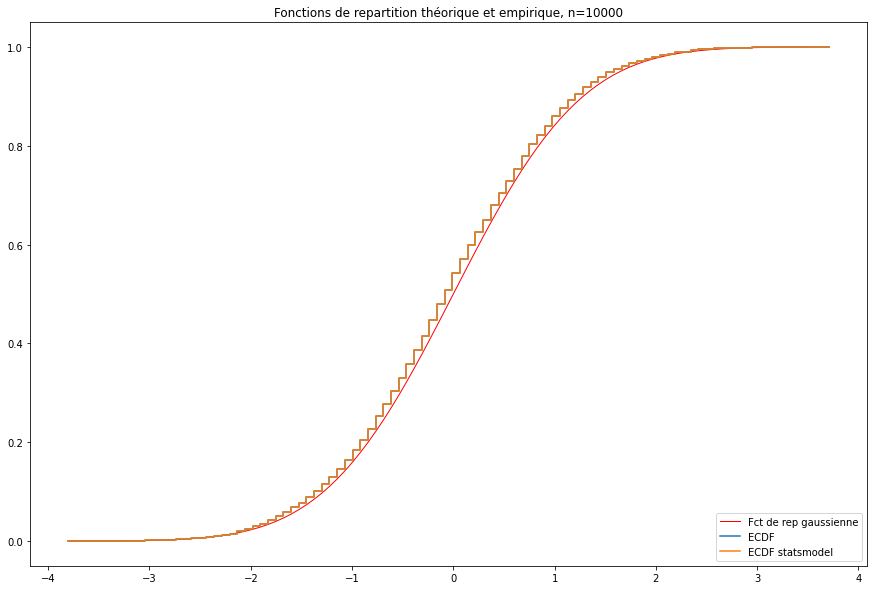

Question 1.2 Cas Gamma


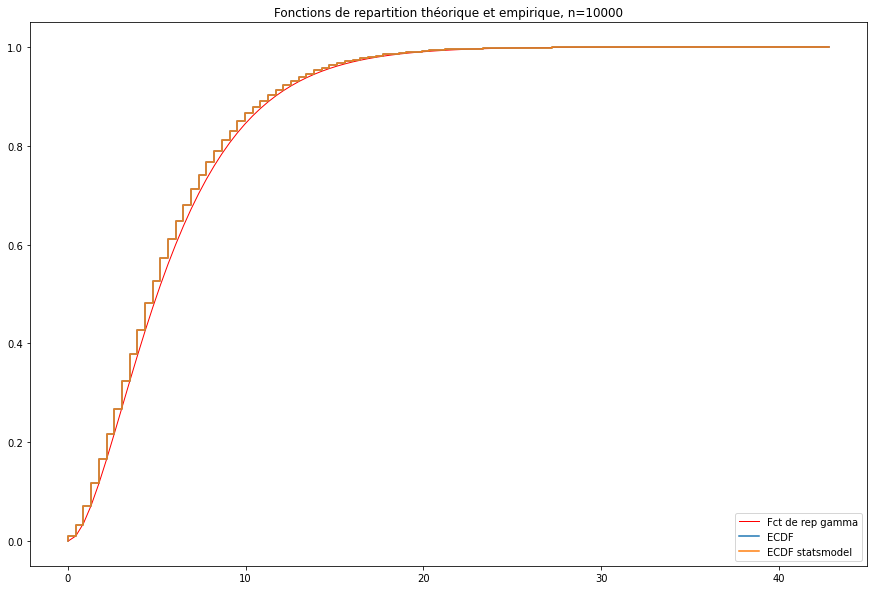

In [ ]:
print("Question 1.2 Cas Gaussien")
## nombre de simulations
n = int(1e4)

## Gaussiennes centrees reduites
# r=norm.rvs
X = norm.rvs(size=n)

plt.figure(figsize=(15, 10))
# Fct de repartition theorique
x = np.linspace(min(X), max(X), 100)
F_x = norm.cdf(x)
plt.plot(x, F_x, "r", linewidth=1.0, label="Fct de rep gaussienne")
plt.title("Fonctions de repartition théorique et empirique, n=%1.0f" %n)

# Fct de repartition empirique
F_x_n = [(1/n)*len(X[X<z]) for z in x]
from statsmodels.distributions.empirical_distribution import ECDF
F_sm = ECDF(X)
## Pensez à utiliser la fonction plt.step pour l'affichage de F_x_n
plt.step(x,F_x_n, label='ECDF')
plt.step(x,F_sm(x), label='ECDF statsmodel')

# On choisit la position de la legende
plt.legend(loc=4)
plt.show()


print("Question 1.2 Cas Gamma")

## Nombre de simulations
n = int(1e4)
## Parametres de la loi Gamma
shape=2
scale=3

######## A completer ######## 
X = gamma.rvs(a=shape , scale = scale,size=n)

plt.figure(figsize=(15, 10))
# Fct de repartition theorique
x = np.linspace(min(X), max(X), 100)
F_x = gamma.cdf(x,a=shape , scale = scale)
plt.plot(x, F_x, "r", linewidth=1.0, label="Fct de rep gamma")
plt.title("Fonctions de repartition théorique et empirique, n=%1.0f" %n)

# Fct de repartition empirique
F_x_n = [(1/n)*len(X[X<z]) for z in x]
from statsmodels.distributions.empirical_distribution import ECDF
F_sm = ECDF(X)
## Pensez à utiliser la fonction plt.step pour l'affichage de F_x_n
plt.step(x,F_x_n, label='ECDF')
plt.step(x,F_sm(x), label='ECDF statsmodel')

# On choisit la position de la legende
plt.legend(loc=4)
plt.show()
# # Maintenant, on fait apparaitre la legende en dehors du graphique
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
# plt.show()

<span style="color:blue">Définition de la fonction Quantile empirique $Q_n$.</span>  À la fonction de répartition empirique $F_n$, on associe la fonction _quantile empirique_ $Q_n$ définie  sur $]0,1[$ par $$ Q_n(u) := \inf\{x\in \mathbb{R} : F_n(x) \geq u \}.$$

<span style="color:blue">Question 1.3. (théorique).</span> Soit $u \in (0,1)$. Montrer que $$Q_{n}(u) = X_{(\lceil nu \rceil,n)},$$ où $\lceil y\rceil$ désigne la partie entière supérieure d'un réel $y$.
> En python, la partie entière supérieure s'obtient par `numpy.ceil(y)`. 

<span style="color:blue">Question 1.4.</span> Montrer que  presque-sûrement, pour  tout $u \in ]0,1[$, $\lim_n Q_n(u) = Q(u)$.

Illustrer graphiquement cette convergence presque-sûre. On pourra comparer la suite des quantiles empiriques à la valeur exacte $Q(u)$, calculable pour les choix de densités $f$ considérés ici à l'aide des fonctions de `scipy.stats`.

Question 1.4 cas Gaussien 

Question 1.4 cas Gamma 



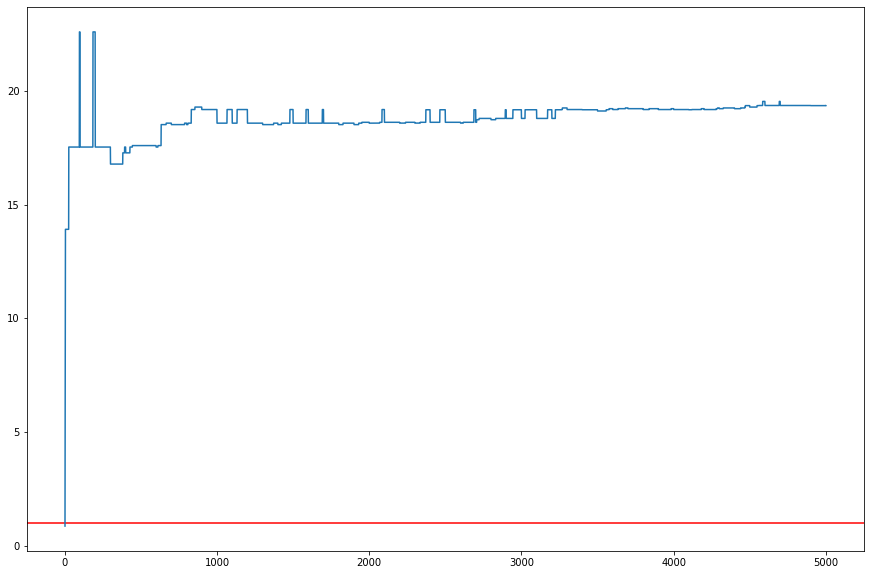

In [ ]:
print("Question 1.4 cas Gaussien \n")

##nombre de simulations
n = 5000
shape=2
scale=3
#Vraie valeur du quantile 
u = 0.99
Q_u = gamma.ppf(u,a=shape , scale = scale)



######## A completer ######## 
X = gamma.rvs(a=shape , scale = scale,size=n)
# X=sorted(X)

Q_emp= [X[int(np.ceil(i*u)) -1] for i in range(1,n+1)]
qemp=[np.sort(X[0:i])[int(np.ceil(u*i)) - 1]  for i in range(1,n+1)]
# Evolution du quantile empirique: A compléter
plt.figure(figsize=(15, 10))
plt.axhline(y=u,color='r')
plt.plot(range(1,n+1),qemp)
print("Question 1.4 cas Gamma \n")


<span style="color:blue">TCL pour l'estimateur $Q_n(u)$.</span> On peut démontrer (voir transparents de l'amphi) que pour tout $u \in \, ]0,1[$,

$$
\sqrt{n}\frac{f(Q(u))}{\sqrt{u(1-u)}}\left(Q_{n}(u)-Q(u)\right) \quad  \stackrel{\text{loi}}{\longrightarrow} \quad  \mathcal{N}(0,1). \qquad \qquad (1)
$$

Cela signifie que, lorsque $n$ est grand, les fluctuations de  $Q_n(u)$ autour de  $Q(u)$ se comportent en loi comme une gaussienne centrée, d'écart-type d'ordre $\frac{ \sqrt{u(1-u)}}{\sqrt{n} \, f(Q(u))}$.  Ce résultat peut en particulier servir à donner une estimation par intervalles de confiance de la quantité $Q(u)$ inconnue.  En pratique, néanmoins, on est confronté à deux difficultés dans l'évaluation de l'écart-type de l'erreur normalisée :  
- le fait que $Q(u)$ n'est pas connu. Le lemme de Slutsky justifie néanmoins de remplacer $Q(u)$ par l'estimateur $Q_n(u)$.  
- le fait que la densité $f$ n'est pas connue.

<span style="color:blue">Question 1.5. Intervalle de confiance, $f$ connue</span>  Dans cette question, on suppose que l'expression de la densité $f$ est connue (mais $Q(u)$ n'est pas connue).

1. Soit $u \in ]0,1[$. Déduire de la convergence en loi (1) l'expression d'un intervalle de confiance asymptotique de probabilité de couverture $95 \%$ pour la quantité $Q(u)$. 

2. Dans le cas où $f$ est la densité d'une loi gaussienne standard, puis le cas où c'est une loi gamma : calculer cet intervalle de confiance à partir de $n$ réalisations de v.a. $X_1, \cdots, X_n$ de loi $f$, et illustrer la convergence en loi (1).


In [ ]:
print("**Question 1.5 cas Gaussien** \n")

##nombre de simulations
n = 5000
def IC(u,n,loi='norm'):
  if loi == 'norm' :
    X = norm(size=n)
    Q_u=norm.ppf(u)
  if loi == 'gamma' :
    X = norm(size=n)
    Q_u=norm.ppf(u)
  qemp=[np.sort(X[0:i])[int(np.ceil(u*i)) - 1]  for i in range(1,n+1)]
  ic=[]
  for i in range(len(qemp)):
    tt=Q_u*np.sqrt(u*(1-u))/(np.sqrt(i)*norm.ppf(qemp[i]))
    ic.append([qemp[i] -tt,qemp[i]+tt])
  return ic




#Vraie valeur du quantile 
u = 0.99
Q_u=norm.ppf(u)

X = norm(size=n)

##################################################
# Compléter avec:
# + le calcul et affichage de l'IC asymptotique
# + l'histogramme de l'erreur normalisee
##################################################


print("**Question 1.5 cas Gamma** \n")


***
$\newcommand{\Var}{\operatorname{Var}}$
<span style="color:blue">Question 1.6. Intervalles de confiance, $f$ inconnue.</span> 
Dans les cas où $f$ n'est pas connue, on peut procéder à une estimation de la variance asymptotique de l'erreur renormalisée apparaissant dans le TCL (voir (1)) afin de pouvoir fournir un intervalle de confiance. Cela est possible, quitte à simuler plusieurs fois l'estimateur $Q_n(u)$.

Nous allons voir une technique alternative, qui utilise un seul jeu de $n$ simulations (le même que celui utilisé pour le calcul de $Q_n(u)$).

1. Montrer que  pour tout $u \in ]0,1[$, 
$$ \sqrt{n} (F_n(Q(u))- F(Q(u)))  = \sqrt{n} (F_n(Q(u))- u)  \stackrel{loi}{\longrightarrow}  \mathcal{N}(0,u(1-u)).$$


2. Soit $u \in ]0,1[$; on pose
$$  u^-_n := u  - 1.96  \,  \frac{\sqrt{u (1-u)}}{\sqrt{n}}, \qquad u^+_n := u + 1.96 \,  \frac{\sqrt{u (1-u)}}{\sqrt{n}}.$$ 
Montrer que $[Q_n(u_n^-),Q_n(u_n^+)[$ est un intervalle de confiance asymptotique de probabilité de couverture  $95\%$ pour $Q(u)$.


3. Illustrer numériquement ce calcul d'intervalle de confiance pour des valeurs de $u=1-\alpha$ allant de $\alpha=10^{-2}$ à $\alpha=10^{-5}$.

In [ ]:
print("*** Question 1.6 Cas Gaussien *** \n")
n=5000
X=norm.rvs(size=n)
qemp=[np.sort(X[0:i])[int(np.ceil(u*i)) - 1]  for i in range(1,n+1)]

def 
print("***Question 1.6 cas Gamma  ***\n")

*** Question 1.6 Cas Gaussien *** 

***Question 1.6 cas Gamma  ***



<span style="color:blue">Espérance conditionnelle de queue.</span>  Une fois le quantile estimé, il est parfois intéressant d'estimer l'*Expected Shortfall*, qui se définit comme étant l'espérance conditionnelle de queue $$E_{1-u}:= \mathbb{E}[X_1\,|\, X_1> Q(u)], \qquad X_1 \sim f. $$ 

<span style="color:blue">Question 1.7.</span>  Dans le cas où $f$ est la loi gaussienne centrée réduite, puis dans le cas où $f$ est la loi gamma : donner un intervalle de confiance asymptotique de probabilité de couverture  $95\%$ pour l'espérance conditionnelle de queue et l'illustrer numériquement.

> Dans cette question, on pourra se contenter d'estimer $Q(u)$ par le quantile empirique, et ensuite utiliser le fait que les variables aléatoires $\{X_i: X_i > X_{(\lceil nu\rceil,n)} \}$ sont approximativement i.i.d. et distribuées selon la loi de $X$ sachant $X> Q(u)$. Plus précisément, on pourra utiliser le fait que les variables aléatoires $\{X_i: X_i > X_{(\lceil n u\rceil,n)} \}$ satisfont à un théorème central limite: le Théorème 4.1 (iii) page 80 [dans ce document](https://tel.archives-ouvertes.fr/tel-00743159/document) fournit des éléments de théorie.

Dans le cas de la loi gaussienne centrée réduite, on pourra comparer avec la valeur exacte $ \quad  (1-u)^{-1} \, f(\Phi^{-1}(u)) \quad $
où $\Phi$ désigne la fonction de répartition de la loi gaussienne centrée réduite. 



In [ ]:
print("*** Question 1.7 : cas Gaussien*** \n")




print ("*** Question 1.7 : cas Gamma*** \n")



***
***
## Exercice 2. Estimation paramétrique
***

Dans cet exercice, on dispose de  données $x_{1}, \ldots,x_{n}$ modélisées comme la réalisation d'un vecteur aléatoire $(X_{1}, \ldots,X_{n})$ que l'on suppose être un $n$-échantillon d'une loi _inconnue_.  On définit un modèle statistique paramétrique : on va chercher la loi qui, dans une famille de lois paramétrique donnée $\{f_\theta, \theta \in \mathbb{R}^d \}$, s'ajuste au mieux aux données. Dans la suite, on prend pour famille de lois:

$$(\mathbb{R}, \mathcal{B}(\mathbb{R}), \{ \mathcal{N}(0,\sigma^2), \sigma^2 > 0 \}). $$

On rappelle que la variance d'une loi $\mathcal{N}(0, \sigma^2)$ est $\sigma^{2}$ et que son moment d'ordre $4$ vaut $3 \sigma^4$. 

<span style="color:blue">Question 2.1. Intervalles de confiance pour $\sigma$.</span> Nous allons d'estimer $\sigma$ à partir de l'observation de $X_1, \ldots, X_n$. 

a)  Utiliser la statistique $M_n : = n^{-1}\sum_{i=1}^n X_i^2$.  Sous $\mathbb{P}_\sigma$, quelle est la loi de $n M_n/\sigma^2$ ? En déduire un intervalle de confiance non asympototique de probabilité de couverture $1-\alpha$.  
Écrire un code donnant un intervalle de confiance (non asymptotique) de probabilité de couverture  $95\%$   pour $\sigma$. 
> Indication : on pourra utiliser la loi du $\chi^{2}$ et la fonction `sps.chi2.ppf`).

Application numérique. 

*** Question 2.1 *** 

[3.54968032e-04 7.15771297e-04 1.04230149e-03 ... 9.99344226e-01
 9.99671238e-01 1.00000000e+00]
74
2924
0.9499575457079411
10.262503160311045
10.981966212955443


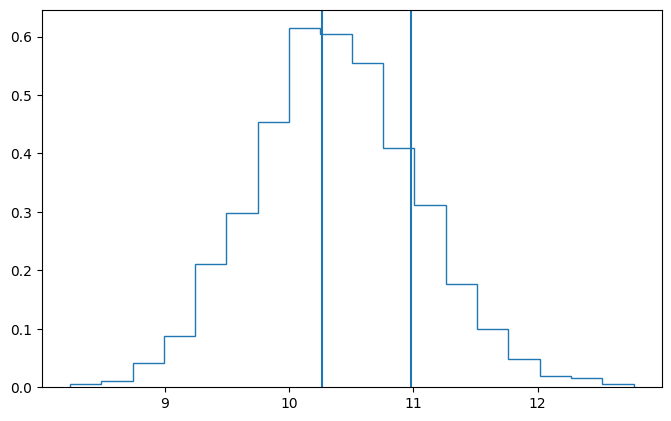

In [ ]:
print ("*** Question 2.1 *** \n")

#####################
## IC non asymptotique
#####################

N=1000
M=3000
sigma = 2*np.random.rand()+1.5
X = np.random.normal(scale=sigma, size=(N, M))

carres = np.square(X).mean(axis=0)
alpha = 0.025


chi2 = np.random.chisquare(df=N, size=M)

sigma_est = N*carres/chi2

fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)

n_bins = 2*int(N**(1/3))
ax.hist(sigma_est, n_bins, density=True, histtype="step")

sigma_cdf = sigma_est.cumsum()/sigma_est.sum()
print(sigma_cdf)
quant1 = np.where(sigma_cdf > alpha)[0][0]
quant2 = np.where(sigma_cdf > 1-alpha)[0][0]
print(quant1)
print(quant2)
print(sigma_cdf[quant2]-sigma_cdf[quant1])
quant1 = sigma_est[quant1]
quant2 = sigma_est[quant2]
print(quant1)
print(quant2)

xrange = np.linspace(sigma_est.min(), sigma_est.max(), 200)

ax.axvline(quant1)
ax.axvline(quant2)

fig.show()


b) Démontrer que  $\sqrt{n} \left(  \sqrt{M_n }-\sigma \right)  \stackrel{loi}{ \rightarrow}  \mathcal{N}(0,\sigma^{2}/2)$. 

c) Écrire un code donnant un intervalle de confiance asymptotique de probabilité de couverture  $95\%$ pour $\sigma$ et basé sur la statistique $M_n$.

In [ ]:
#####################
## IC asymptotique
#####################


<span style="color:blue">Question 2.2. Intervalles de confiance pour $Q(u,\sigma)$.</span>  Notons $Q(u,\sigma)$ le quantile en $u$ de la loi $\mathcal{N}(0,\sigma^{2})$. On admettra que
$$\sqrt n \left(Q \left( u, \sqrt{M_n} \right)  - Q(u,\sigma) \right)
 \stackrel{loi}{\longrightarrow} \mathcal{N} \left(0, \frac{Q(u,\sigma)^2}2 \right).  \qquad \qquad (2)
$$

Cette relation entraine en particulier que $Q(u,\sqrt{M_n})$ est un estimateur consistant de $Q(u,\sigma)$.



On veut estimer le quantile $Q(u,\sigma)$ ainsi qu'un intervalle de confiance asymptotique à $95\%$ de $Q(u,\sigma)$. Comparer, pour différentes valeurs de $n$,  
- la valeur exacte du quantile $Q(u,\sigma)$,  

_méthode 1_
- la valeur obtenue en estimant $\sigma$ puis en calculant le quantile par `scipy.stats.norm.ppf`, 
- un IC asymptotique pour $Q(u,\sigma)$ obtenu en exploitant (2). 

_méthode 2_
- l'estimateur de quantile empirique (voir exercice 1)
- l'IC asymptotique obtenu en utilisant le TCL (1) de l'exercice 1.  

_méthode 3_
- l'IC asymptotique obtenu en utilisant la question 1.6 de l'Exercice 1.


On pourra faire cette expérience notamment pour des valeurs de $u$ proches de $1$.


In [ ]:
print ("*** Question 2.2 *** \n")



*** Question 2.2 *** 



***
<span style="color:blue">Question 2.3. (facultative).</span> Démontrer la convergence en loi (2) apparaissant dans la Question 2.2.

***
***
## Exercice 3. Théorème ergodique et méthode de splitting
***

#### A. Théorème ergodique pour le processus $\operatorname{AR}(1)$ stationnaire ####

Un processus $\operatorname{AR}(1)$ gaussien stationnaire est défini par récurrence comme suit (pour simplifier, on se place en dimension $1$).  On fixe $\rho\in ]-1,1[$ et on pose pour $i\ge 1$,

$$
X_i := \rho X_{i-1}+\sqrt{1-\rho^2}  Y_i, \qquad \qquad  X_0 = Y_0 \qquad (3)
$$

où $(Y_i)_{i\ge 0}$ est une suite de variables aléatoires i.i.d. de loi 
$\mathcal{N}(0, 1)$, indépendante de $X_0$.
C'est donc un processus qui se renouvelle d'un instant à l'autre en gardant une part de son ancienne valeur ($\rho X_{i-1}$) et en ajoutant une part d'_innovation_ $\sqrt{1-\rho^2} Y_i$.

De façon équivalente, nous avons 
$$
X_i\;=\;\rho^i X_0+\sqrt{1-\rho^2}\sum_{j=1}^{i}\rho^{i-j}Y_{j}. \qquad \qquad \qquad (4)
$$

> L'expression de $X_i$ dans l'équation (3) se prête naturellement à une implémentation avec une boucle `for`.  Cette expression exprime clairement la propriété markovienne du processus $(X_i)_i$.  
L'équation (4) permet d'effectuer des calculs plus rapides que (3) en utilisant la programmation matricielle de `numpy` plutôt que des boucles, mais, d'un autre coté, elle peut mener à des problèmes de précision lorsque $i\gg 1$, puisqu'elle amène à calculer des expressions du type $\rho^{\textrm{(très grand nombre)}}$.
Nous déconseillons donc l'usage de l'expression (4) en pratique. Sous l'angle de vue probabiliste, l'avantage de l'equation (4) est de permettre un calcul rapide de la loi de $X_i$ en tant que combinaison linéaire de v.a. gaussiennnes i.i.d. On peut vérifier que pour tout $i \geq 0$, $X_i \sim  \pi_\star := \mathcal{N}(0,1)$.

<span style="color:blue">Théorème ergodique.</span>  Il affirme que 
pour tout  $B\subset \mathbb{R}$ mesurable, presque sûrement, 
$$\frac{1}{n}\sum_{i=1}^n 1_{X_i\in B} \quad \mathop{\longrightarrow}_{n \to \infty}  \quad \mathbb{P}(Z\in B), \qquad \textrm{où } Z \sim \mathcal{N}(0,1) . \qquad \qquad \qquad (5)$$

> Nous avons vu que la chaîne de Markov était stationnaire (les v.a. $X_i$ ont même loi) et de loi stationnaire $\pi_\star$.  C'est cette loi stationnaire qui apparaît comme loi limite dans le théorème ergodique.

Concrètement, pour $n\gg 1$, l'histogramme de $X_1, \ldots, X_n$ est proche de la densité de $\mathcal{N}(0, 1)$. 

<span style="color:blue">Question 3.1.</span> Illustrer la proximité entre l'histogramme de l'échantillon $(X_i)_{1 \le i \le n}$ et la loi $\mathcal{N}(0,1)$.

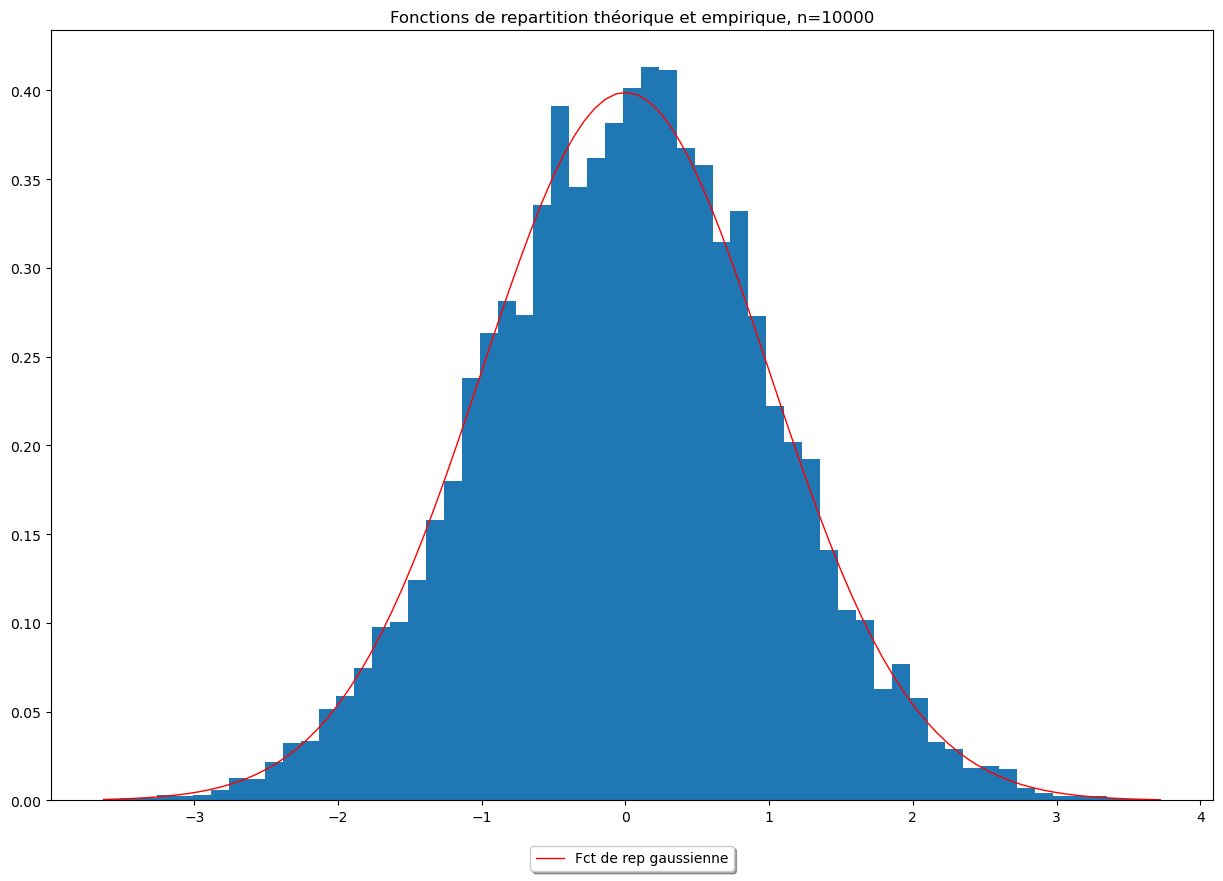

In [6]:
#### Question 3.1 ####


## nombre de simulations
n = int(1e4)
rho=.7
rrho=np.sqrt(1-rho**2)
## Gaussiennes centrees reduites
# r=norm.rvs
Y = norm.rvs(size=n)
X=np.random.randn(n)

plt.figure(figsize=(15, 10))
# Fct de repartition theorique

for i in range(len(X)):
  X[i]=rho*X[i]+rrho*Y[i]



x = np.linspace(min(X), max(X), 100)
F_x = norm.pdf(x)
plt.plot(x, F_x, "r", linewidth=1.0, label="Fct de rep gaussienne")
plt.hist(X,bins='auto',density=True)
plt.title("Fonctions de repartition théorique et empirique, n=%1.0f" %n)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)




#### B. Théorème ergodique et méthode de splitting ####


Si l'on modifie la dynamique du processus $X$ dans (3) en conditionnant à l'appartenance à un ensemble mesurable $A\subset \mathbb{R}$,  la convergence (5) reste valable (au sens conditionnel). Soit $A\subset \mathbb{R}$  un ensemble mesurable de mesure de Lebesgue strictement positive. 

Soit $\tilde X_0$ une v.a. de  loi gaussienne centrée réduite conditionnée à appartenir à $A$. Etant données une suite de v.a. $(Y_i)_i$ i.i.d. de loi $\mathcal{N}(0,1)$ et indépendantes de $\tilde X_0$, on définit pour pour tout $i \geq 1$,
$$
 \tilde X_{i+1/2}:=  \rho \tilde X_{i-1} +\sqrt{1-\rho^2} Y_i, \qquad Y_i \sim \mathcal{N}(0,1), 
$$
puis 
\begin{equation*}\label{eqAR(1)2} \tilde X_{i+1} := \begin{cases} \tilde X_{i+1/2} & \textrm{ si $\tilde X_{i+1/2}\in A$,}\\ \tilde X_{i} &\textrm{ sinon,}\end{cases} \qquad \qquad (6)
\end{equation*}
On a  
- pour tout $i \geq 0$, $\tilde X_i$ suit la loi gaussienne centrée réduite conditionnée à appartenir à $A$,  
- le théorème ergodique reste valable: pour tout $B\subset \mathbb{R}$  mesurable,  presque sûrement
\begin{equation*}\label{eqAR(1)TE2}
\frac{1}{n}\sum_{i=1}^n 1_{\tilde X_i \in B}  \quad \mathop{\longrightarrow}_{n \rightarrow \infty} \quad \mathbb{P}(Z\in B \,|\, Z\in A)\qquad \qquad   Z\sim \mathcal{N}(0, 1) \qquad (7)\end{equation*}


<span style="color:blue">Question 3.2.</span>  Prendre $A := [a,+\infty[$.
Illustrer la proximité entre l'histogramme de l'échantillon $( \tilde X_i)_{1 \le i \le n}$ et la loi conditionnelle de $Z$ sachant $\{Z \in A\}$, où $Z \sim \mathcal{N}(0,1)$. 

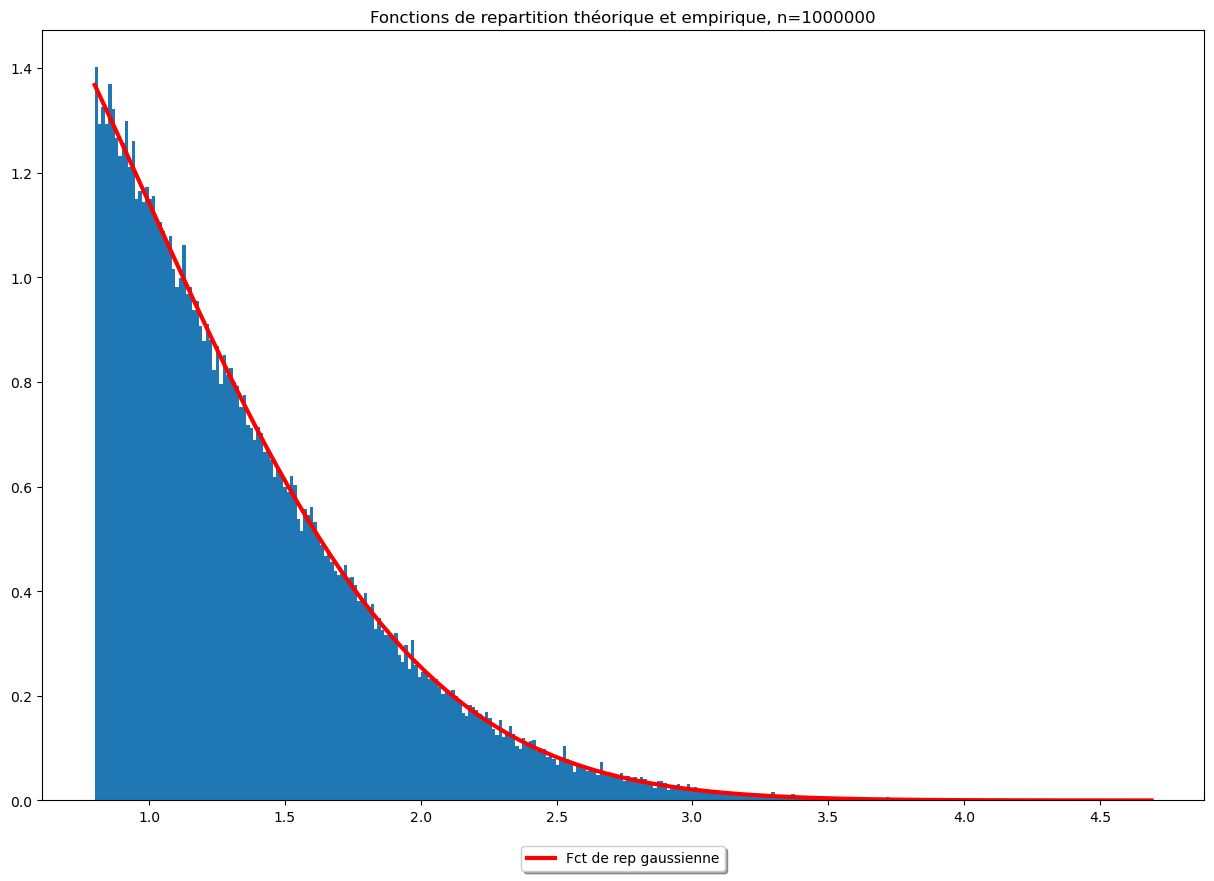

In [9]:
#### Question 3.2 ####
n = int(1e6)
rho=.7
rrho=np.sqrt(1-rho**2)
a=.8
## Gaussiennes centrees reduites
# r=norm.rvs
Y = norm.rvs(size=n)
X=np.random.randn(n)

x0=np.random.randn(1)
while x0 < a :
  x0=np.random.randn(1)
X[0]=x0


plt.figure(figsize=(15, 10))
# Fct de repartition theorique

for i in range(1,len(X)):
  t=rho*X[i]+rrho*Y[i]
  X[i]=t*(t>a)+X[i-1]*(t<=a)



x = np.linspace(min(X), max(X), 100)
F_x = norm.pdf(x)/norm.sf(a)
plt.plot(x, F_x, "r", linewidth=3.0, label="Fct de rep gaussienne")
plt.hist(X,bins='auto',density=True)
plt.title("Fonctions de repartition théorique et empirique, n=%1.0f" %n)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)







<span style="color:blue">Méthode de splitting.</span> Pour calculer $\mathbb{P}(Z\in A)$, l'idée du _splitting_ est  d'utiliser une suite décroissante de "cibles"
$\mathbb{R}=A_0\supset A_1\supset\cdots\supset A_k=A$
et de calculer $\mathbb{P}(Z\in A)$ avec la formule 

\begin{equation*} 
\mathbb{P}(Z\in A)=\prod_{\ell=1}^k \mathbb{P}(Z\in A_{\ell}\,|\, Z\in A_{\ell-1}) \qquad \qquad (8)
\end{equation*}

où chaque probabilité conditionnelle est approchée via la limite (7), à l'aide de v.a. $(\tilde X_i^{(\ell)})_i$  simulées selon l'algorithme (6) appliqué avec $A \leftarrow A_{\ell-1}$.

<span style="color:blue">Question 3.3.</span>  Illustrer la méthode de splitting pour le calcul de $\mathbb{P}(Z>a)$ pour $Z\sim \mathcal{N}(0,1)$, $a=4$ et $\rho = 0.6$.

La valeur de cette probabilité est connue et accessible via les fonctions `scipy.stats.norm.pdf` ou `scipy.stats.norm.sf`. On souhaite ici tester les performances d'un algorithme d'estimation basé sur la représentation (8) et sur le résultat de convergence (7), dans un cas simple.

Plus précisément, on pourra tester l'algorithme suivant :  
- Etape 1: on idéntifie des ensembles $A_l$ raisonnables. En utilisant un nombre $n$ de tirages pas très élevé ($n=500$ ou $n=1000$ par exemple), on estime, en se basant sur la convergence (7), des valeurs
$$
-\infty=a_0<a_1<\cdots <a_k < a \leq a_{k+1}
$$
telles que pour tout $\ell$,
$$
\mathbb{P}(Z>a_\ell\,|\,Z>a_{\ell-1})
\simeq 0.1.
$$

> Indication : penser au fait que le calcul de $a_\ell$ (une fois que $a_{\ell-1}$ est connu) revient à l'estimation d'un quantile! Pour cela, on pourra admettre que les théorèmes limites de l'Exercice 1 restent vrais pour l'échantillon $(\tilde X_i^{(\ell)})_i$.


- Etape2: on estime alors chacune des probabilités conditionnelles $\mathbb{P}(Z>a_\ell\,|\,Z>a_{\ell-1})$ via une méthode encore fondée sur (7), en utilisant maintenant un nombre de tirages plus élevé (par exemple de l'ordre de $n=5.10^4$). On estime aussi, pour la dernière probabilité : $\mathbb{P}(Z>a \,|\, Z > a_k)$. 

> Attention, en toute rigueur, $k$ est un nombre aléatoire; ce que les notations utilisées dans cette section ne reflètent pas, pour simplifier l'exposé.*


3. On en déduit  $\mathbb{P}(Z>a)$ via la formule (8), et on compare le résultat obtenu à la valeur approchée obtenue par un Monte-Carlo simple réalisé avec autant de simulations (càd avec $n \, k$ simulations), ainsi qu'à la valeur exacte donnée par la fonction `scipy.stats.norm.sf`.

In [18]:
#### Question 3.3 ####
n=int(1e4)
rho=.7
rrho=np.sqrt(1-rho**2)
a=5
seuil=.1
## Gaussiennes centrees reduites
# r=norm.rvs
Y = norm.rvs(size=n)
X=np.random.randn(n)

# x0=np.random.randn(1)
# while x0 < a :
#   x0=np.random.randn(1)
# X[0]=x0
for i in range(1,len(X)):
  X[i]=rho*X[i-1]+rrho*Y[i]
X.sort()

quantiles = np.array([])
quantiles = np.append(quantiles, X[int(np.ceil((1-seuil)*n))-1] )
# print("niveau 1 : {}".format(quantiles[-1]))
while quantiles[-1]<a:
  sp=X[X>quantiles[-1]][0]
  X=np.array([sp])
  y=np.random.randn(n)
  for i in range(n):
    t=rho*X[-1]+rrho*y[i]
    X=np.append(X,t*(t>quantiles[-1])+X[-1]*(t<=quantiles[-1]))
  X.sort()
  quantiles=np.append(quantiles,X[int(np.ceil((1-seuil)*n))-1])


q=np.append(quantiles[:-1],a)

print(q)

m=int(1e4)



SyntaxError: invalid syntax (749943214.py, line 38)

***
***
## Exercice 4. Estimation de la densité
***

Dans cet exercice, on considère une suite $(X_i)_{i\ge 1}$ de aléatoires i.i.d. dont on suppose qu'elles ont une densité $f$ sur $\R$. Afin d'estimer $f$, pour chaque valeur de $n$, on va construire, à partir des observations $X_1, \ldots, X_n$, une densité $f_n$.
Cette densité pourra, selon la stratégie choisie, être construite via différents procédés, et on verra dans quelle mesure, pour $x\in \R$,
$$
f_n(x)\underset{n\to\infty}{\longrightarrow} f(x).
$$

#### A. Histogramme ####

Pour chaque valeur de $n$, on fixe une subdivision $a_{n,0}<a_{n,1}<\cdots$ de $\R$, et $f_n$ est la fonction constante sur chaque intervalle $]a_{n,k-1}, a_{n,k}]$ telle que  pour tout $k$,

$$\int^{a_{n,k}}_{a_{n,k-1}}f_n(x)\textrm{d} x
=
\frac 1 n 
\textrm{Card}\{i\in \{1, \ldots, n\}: a_{n,k-1} < X_i\le a_{n,k}\}
= F_n(a_{n,k}) - F_n(a_{n,k-1}).
$$

Rappelons que dans `matplotlib.pylot`, la fonction `hist` trace un histogramme de la manière suivante: pour `V` un vecteur de données, on peut tracer  l'histogramme de `V` selon deux procédés: 

1. Pour tout entier `n`, la commande `hist(V, bins=n)` (ou simplement `hist(V, n)`) trace l'histogramme associé à la subdivision régulière à `n` intervalles, allant du plus petit élément de `V` au plus grand.

2. On peut aussi prescrire la subdivision utilisée dans le traçage de l'histogramme en remplaçant l'argument `n` par une subdivision (i.e. un vecteur de réels croissants sous la forme d'un \src{list} ou d'un `numpy.array`). Dans ce cas, les valeurs de `V` qui sont hors des bornes de la subdivision ne sont pas prises en compte.

#### B. Fenêtres glissantes ####
Pour chaque valeur de $n$, on fixe $h_n>0$ (la _largeur de fenêtre_) et on définit la densité $f_n$ par la formule :
 
$$\label{def_fenetre_gli}\forall x\in \R, \qquad f_n(x) := 
\frac 1 {n \, h_n}
\textrm{Card}\Big\{i\in \{1, \ldots, n\}: x-\frac{h_n}{2}< X_i\le x+\frac{h_n}{2}\Big\}. \qquad \qquad (9)
 $$

#### C. Comment choisir la largeur des colonnes de l'histogramme ou des fenêtres glissantes ? ####

On unifie les approches des deux paragraphes précédents en notant $f_n$ la densité empirique construite soit via l'approche "histogramme", soit via l'approche "fenêtres glissantes".

Il est facile d'imaginer ce qu'il se produit si l'histogramme a trop peu de colonnes ou si les fenêtres glissantes sont trop larges: l'approximation de la densité qui en résulte est très grossière. 

Néanmoins, augmenter le nombre de colonnes excessivement ou affiner les fenêtres glissantes à l'extrême ne produit pas non plus une bonne approximation de la densité: cela augmente la variance dans l'estimation de $f$ dans chaque colonne (ou fenêtre).

#### Question 4.1 ####

$\blacktriangle$ Illustrer les deux assertions précédentes (pour l'approche  _histogramme_ uniquement) avec une simulation : on tire $n$ variables aléatoires i.i.d. ayant une densité $f$ (par exemple des gaussiennes standard) et on compare la densité $f$ à son approximation via un histogramme en choisissant soit très peu, soit beaucoup  de colonnes.

$\blacktriangle$ La question du choix optimal pour la largeur des colonnes (ou des fenêtres) est délicate, notamment car sa réponse dépend fortement de l'information disponible quant à la densité $f$ à approcher.
Dans l'article [Scott 79](https://www.jstor.org/stable/2335182?seq=1#metadata_info_tab_contents), il est suggéré d'utiliser une largeur de colonne égale à $a \, \sigma_n  \, n^{-1/3}$, où $a=3.49$, $\sigma_n$ est l'écart-type  de l'échantillon et $n$ est la taille de l'échantillon  (dans le cas de la densité gaussienne, ce choix minimise une erreur quadratique). Cela signifie que si notre échantillon s'étale sur un intervalle de longueur $L$, notre histogramme devra avoir $N\approx \frac{n^{1/3}L}{a \, \sigma_n}$ colonnes. Illustrer cette affirmation avec des simulations  de variables aléatoires i.i.d. suivant diverses lois.

In [ ]:
### Question 4.1 ###

